In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Reshape, Add, Conv2DTranspose
from PIL import Image
import pandas as pd
from keras import backend as K
import imageio
from tensorflow import keras
from tensorflow.keras import layers, Input
import os
from tensorflow.keras.preprocessing.image import load_img

In [2]:
#import the data (stopper not removed)

resolution = 200

#lst = [300K ,320K ,340K, 360K, 380K, 400K, 420K, 440K, 460K, 480K, 500K, 550K, 600K, 650K, 700K, 800K]
#Each class corresponds to a range of temperatures, defined by the above list:
#0: x < lst[0]
#1 - 15: lst[i] <= x < lst[i+1]
#16: lst[16] <= x

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

new_train_dir = 'D:\\Uni\\Year 4\\Research\\cGAN\\new_training\\'

images =[]
one_hot = []


#The training data (lab images) was labelled using analytical means (and are stored in directories seperated by labels) 
#Extracting these images and their labels:
for i in classes:
    files = os.listdir('D:\\Uni\\Year 4\\Research\\cGAN\\new_training\\' + str(i))
    for file in files:
        
        onimg = load_img(new_train_dir + str(i) + '\\' + file, color_mode = "grayscale", target_size = (resolution, int(1.148*resolution)), interpolation = 'nearest')
        onimg = onimg.crop((int(0.1*resolution), 0, int(1.1*resolution), resolution))
        onimg = np.reshape(onimg, (resolution, resolution))
        onimg = onimg.astype(np.int16)
    
        images.append(onimg/12000)
        one_hot.append(keras.utils.to_categorical(i, 17))
        
imgs = np.concatenate(images)
labels = tf.convert_to_tensor(np.array(one_hot), 'float32')
imgs = tf.convert_to_tensor(np.reshape(imgs, (-1, resolution, resolution, 1)),'float32')
        
dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))

dataset = dataset.repeat(500)

In [2]:
#import the data (stopper removed)

resolution = 200

#lst = [300K ,320K ,340K, 360K, 380K, 400K, 420K, 440K, 460K, 480K, 500K, 550K, 600K, 650K, 700K, 800K]
#Each class corresponds to a range of temperatures, defined by the above list:
#0: x < lst[0]
#1 - 15: lst[i] <= x < lst[i+1]
#16: lst[16] <= x

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

new_train_dir = 'D:\\Uni\\Year 4\\Research\\cGAN\\stopper_training\\'

images =[]
one_hot = []


#The training data (lab images) was labelled using analytical means (and are stored in directories seperated by labels) 
#Extracting these images and their labels:
for i in classes:
    files = os.listdir('D:\\Uni\\Year 4\\Research\\cGAN\\stopper_training\\' + str(i))
    for file in files:
        
        onimg = load_img(new_train_dir + str(i) + '\\' + file, color_mode = "grayscale", target_size = (resolution, int(1.148*resolution)), interpolation = 'nearest')
        onimg = onimg.crop((int(0.1*resolution), 0, int(1.1*resolution), resolution))
        onimg = np.reshape(onimg, (resolution, resolution))
        onimg = onimg.astype(np.int16)
    
        images.append(onimg/12000)
        one_hot.append(keras.utils.to_categorical(i, 17))
        
imgs = np.concatenate(images)
labels = tf.convert_to_tensor(np.array(one_hot), 'float32')
imgs = tf.convert_to_tensor(np.reshape(imgs, (-1, resolution, resolution, 1)),'float32')
        
dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))

dataset = dataset.repeat(500)

(407, 200, 200, 1)
(407, 17)


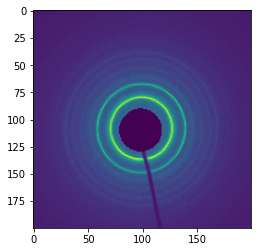

In [3]:
batch_size = 16
num_channels = 1
num_classes = 17
image_size = resolution
latent_dim = 128

dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
print(imgs.shape)
print(labels.shape)
dataset

plt.imshow(np.clip(images[4], 0, 1))


In [4]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

145 18


In [5]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((resolution, resolution, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        MaxPooling2D(2,2),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.5),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        MaxPooling2D(2,2),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.5),
        layers.GlobalMaxPooling2D(),
        layers.Dense(10),
        layers.LeakyReLU(alpha = 0.2),
        layers.Dense(1),
    ],
    name="discriminator",
)

generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(1000),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.5),
        layers.Dense(2500),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.5),
        layers.Dense(5202),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.5),
        layers.Reshape((51, 51, 2)),
        layers.Conv2DTranspose(4, (4, 4), strides=(2, 2), padding = "same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(8, (4, 4), strides=(1, 1), padding = "same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(16, (4, 4), strides = (2, 2), padding = "same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, (4, 4), strides = (1, 1), padding = "same"),
        layers.Conv2D(1, (5, 5), activation="sigmoid"),
    ],
    name="generator",
)

In [6]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1000)              146000    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_3 (Dense)              (None, 2500)              2502500   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 2500)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2500)              10000     
_________________________________________________________________
dense_4 (Dense)              (None, 5202)              13

In [7]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      10432     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 128)     

In [8]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.disc_acc_tracker = tf.keras.metrics.Accuracy(name = "discriminator_acc")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.disc_acc_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        self.disc_acc_tracker.update_state(labels, tf.math.round(predictions)) #MY OWN CHANGE
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            ########### Here I'm Adding an L1 loss function as well ##################
            g_loss = self.loss_fn(misleading_labels, predictions) + tf.keras.losses.MeanAbsoluteError()(generated_images, real_images)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "d_acc": self.disc_acc_tracker.result() #MY OWN CHANGE
        }

In [9]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [10]:
history = cond_gan.fit(dataset, epochs = 75, steps_per_epoch = 407//batch_size, verbose = 1)

Epoch 1/75
25/25 [==============================] - 19s 231ms/step - g_loss: 1.1082 - d_loss: 0.6459 - d_acc: 0.4971
Epoch 2/75
25/25 [==============================] - 6s 231ms/step - g_loss: 0.8275 - d_loss: 0.7347 - d_acc: 0.4772
Epoch 3/75
25/25 [==============================] - 6s 230ms/step - g_loss: 0.8658 - d_loss: 0.6780 - d_acc: 0.4979
Epoch 4/75
25/25 [==============================] - 6s 231ms/step - g_loss: 1.0050 - d_loss: 0.5675 - d_acc: 0.4234
Epoch 5/75
25/25 [==============================] - 6s 231ms/step - g_loss: 1.0843 - d_loss: 0.6070 - d_acc: 0.4219
Epoch 6/75
25/25 [==============================] - 6s 231ms/step - g_loss: 1.0278 - d_loss: 1.0688 - d_acc: 0.2177
Epoch 7/75
25/25 [==============================] - 6s 230ms/step - g_loss: 2.2290 - d_loss: 0.3720 - d_acc: 0.5576
Epoch 8/75
25/25 [==============================] - 6s 232ms/step - g_loss: 3.8963 - d_loss: 0.0589 - d_acc: 0.0000e+00
Epoch 9/75
25/25 [==============================] - 6s 230ms/step -

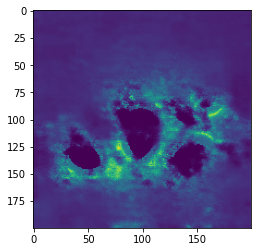

In [11]:
trained_gen = cond_gan.generator

random_latent_vector = tf.random.normal(shape=(1, latent_dim))
label = keras.utils.to_categorical([1], 17)
noise_and_labels = tf.concat([random_latent_vector, label], 1)

fake_image = trained_gen.predict(noise_and_labels)

plt.imshow(fake_image.reshape(200,200))

In [12]:
def plot_loss(history, start_point):

    g_loss = history.history['g_loss']
    d_loss = history.history['d_loss']
    
    d_acc = history.history['d_acc']

    epochs = range(len(g_loss))
    
    plt.figure(1)
    plt.plot(epochs[start_point:], g_loss[start_point:], 'r', label = 'Generator Loss')
    plt.plot(epochs[start_point:], d_loss[start_point:], 'b', label = 'Discriminator Loss')
    plt.title('Generator and Discriminator Loss')
    plt.legend(loc = 0)
    
    plt.figure(2)
    plt.plot(epochs[start_point:], d_acc[start_point:], 'r')
    plt.title('Discriminator Accuracy')


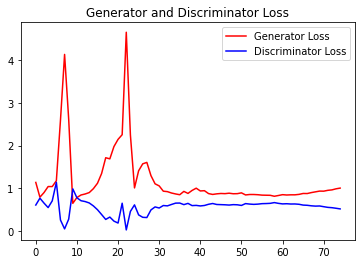

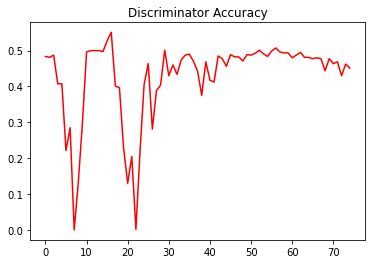

In [13]:
plot_loss(history, 0)

In [13]:
for key in history.history:
    print(key)
    
print(history.history)

g_loss
d_loss
d_acc
{'g_loss': [0.8733664155006409, 0.655476987361908, 0.7649412751197815, 0.7875078320503235, 0.9979795813560486, 1.3066679239273071, 1.8220281600952148, 2.485196352005005, 3.170625686645508, 1.1125091314315796], 'd_loss': [0.5674450397491455, 0.7618125081062317, 0.6476342082023621, 0.6534966826438904, 0.5175433158874512, 0.3703313171863556, 0.21333396434783936, 0.11075542122125626, 0.05758927762508392, 0.9643353819847107], 'd_acc': [0.4325000047683716, 0.48249998688697815, 0.4625000059604645, 0.5049999952316284, 0.48500001430511475, 0.42500001192092896, 0.23624999821186066, 0.03500000014901161, 0.0037499999161809683, 0.5099999904632568]}
